### RRT Star

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import shapely as sp
import matplotlib.pyplot as plt
from networkx.algorithms.traversal.depth_first_search import dfs_edges
from shapely import Polygon
from rrt import RapidlyExploringRandomTreesStarClass
from util import is_point_feasible,is_point_to_point_connectable
np.set_printoptions(precision=2,suppress=True,linewidth=100)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("networkx version:[%s]"%(nx.__version__))
print ("shapely version:[%s]"%(sp.__version__))

networkx version:[3.0]
shapely version:[2.0.1]


### Instantiate RRT*

In [2]:
RRT = RapidlyExploringRandomTreesStarClass(
    name='RRT-Star-2D',point_min=np.array([-1,-1]),point_max=np.array([+1,+1]),
    steer_len_max=0.1,search_radius=0.2,norm_ord=2)
print ("[%s] instantiated."%(RRT.name))

[RRT-Star-2D] instantiated.


### Set obstacles

In [3]:
# Set obstacles
obs_list = []
obs_list.append(Polygon([(0.25,0.5),(0.25,-0.5),(0.5,-0.5),(0.5,0.5)]))
obs_list.append(Polygon([(0.5,0.5),(-0.5,0.5),(-0.5,0.25),(0.5,0.25)]))
obs_list.append(Polygon([(-0.5,0.5),(-0.5,-0.5),(-0.25,-0.5),(-0.25,0.5)]))
obs_list.append(Polygon([(0.25,-0.5),(1.0,-0.5),(1.0,-0.25),(0.25,-0.25)]))
print ("Ready.")

Ready.


### Loop

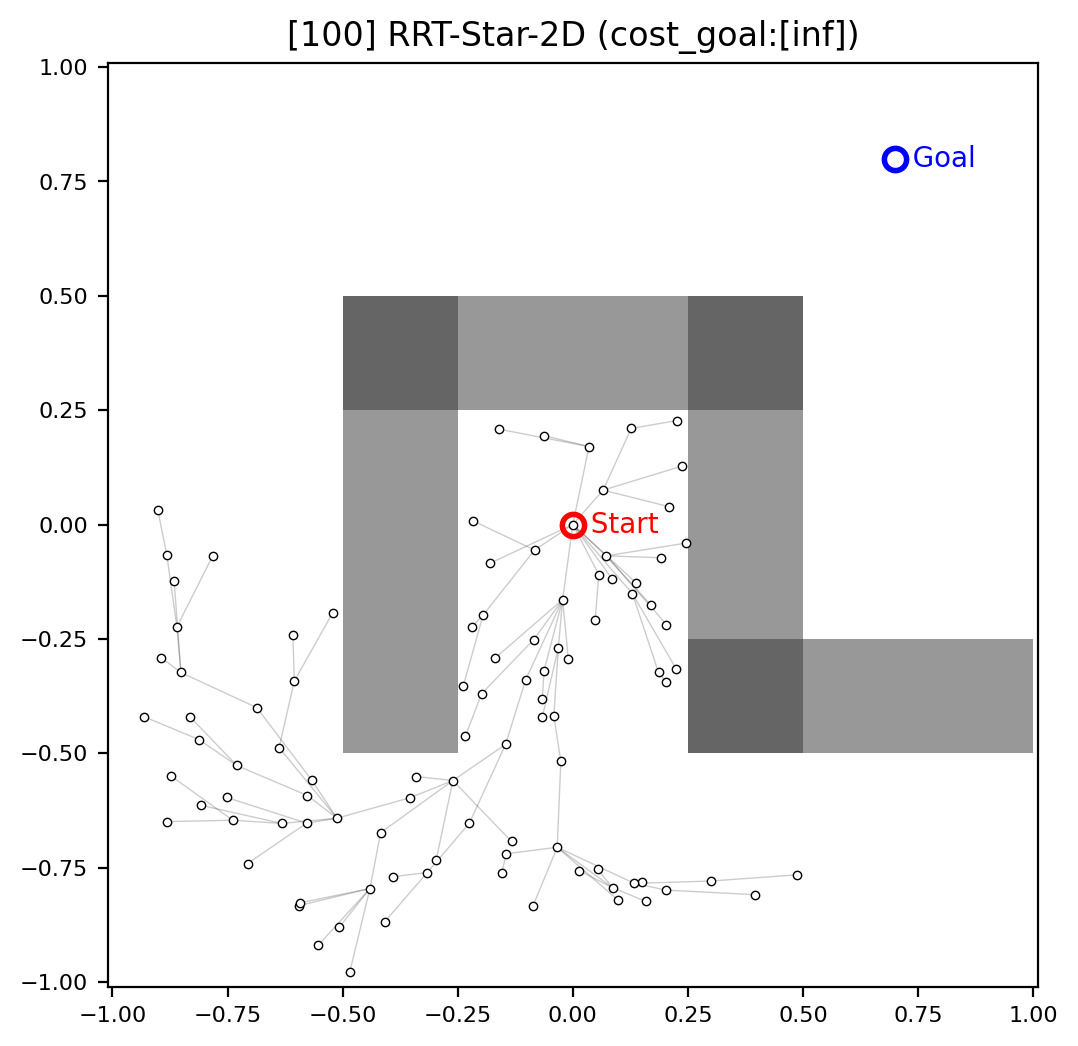

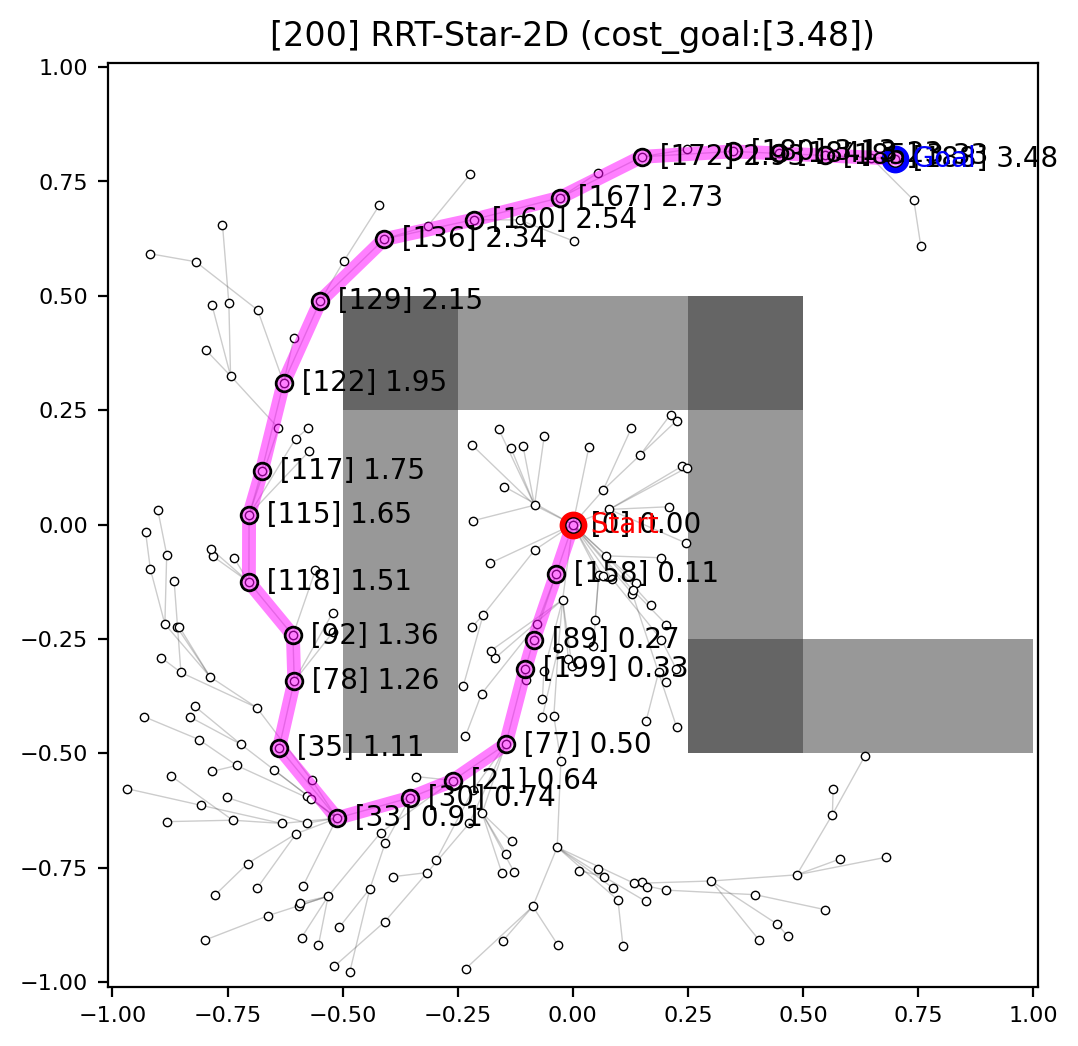

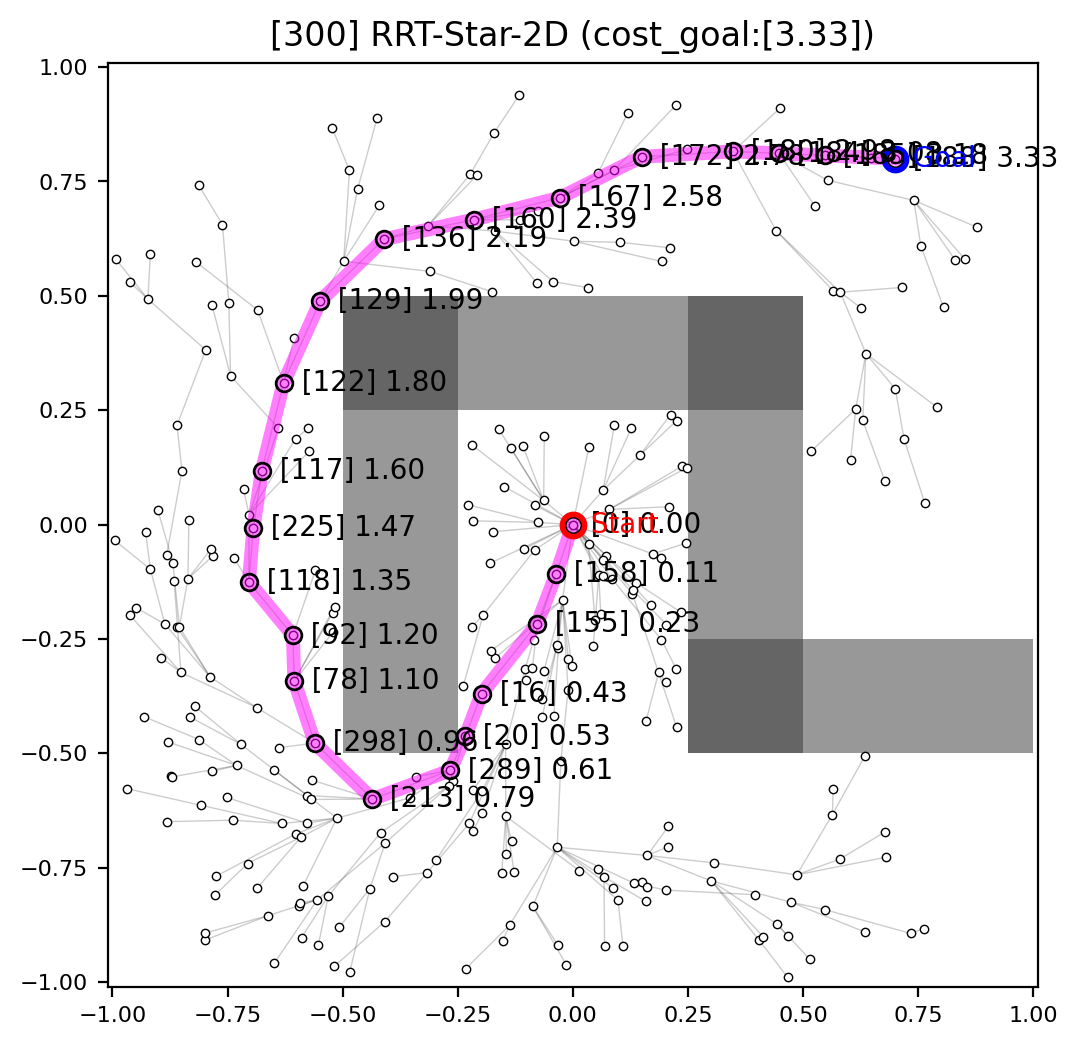

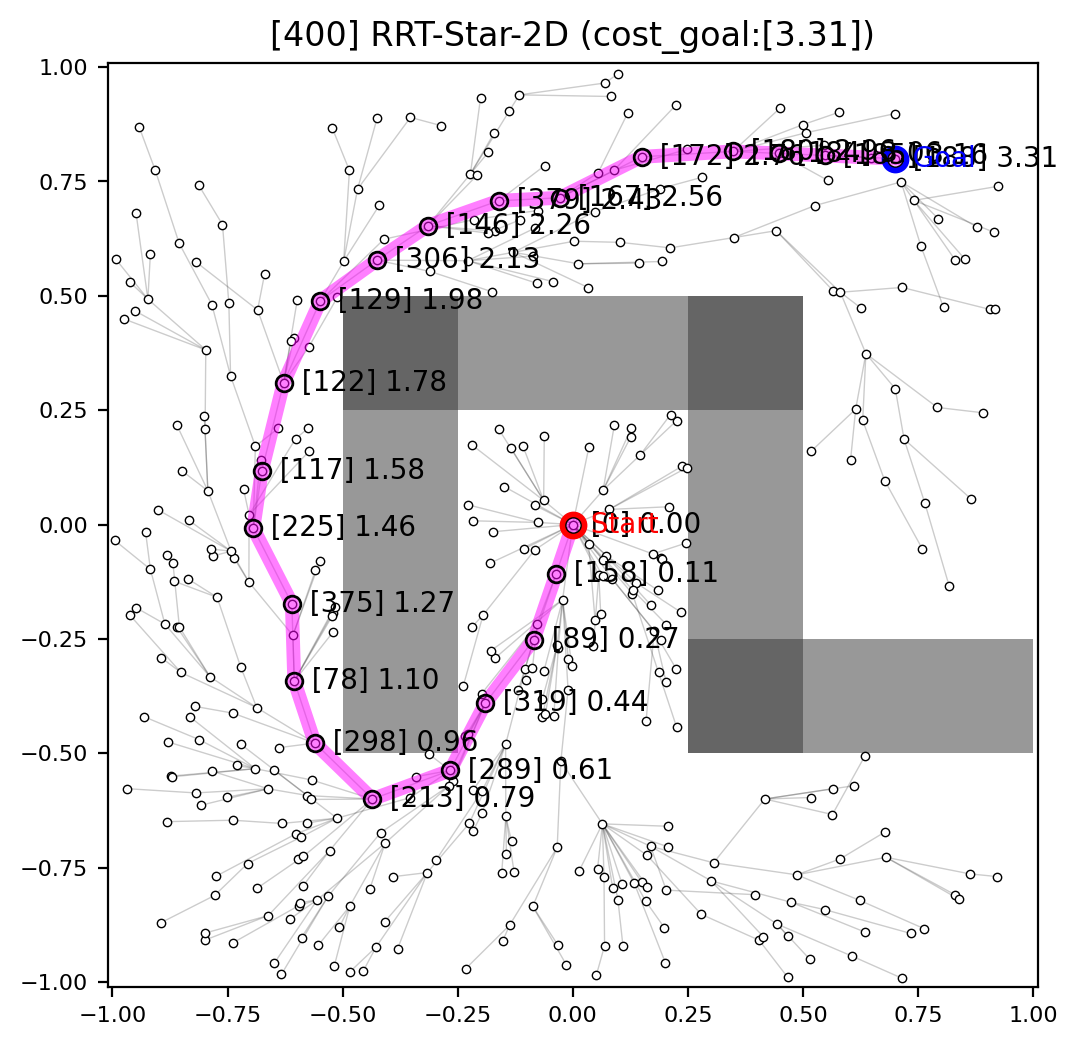

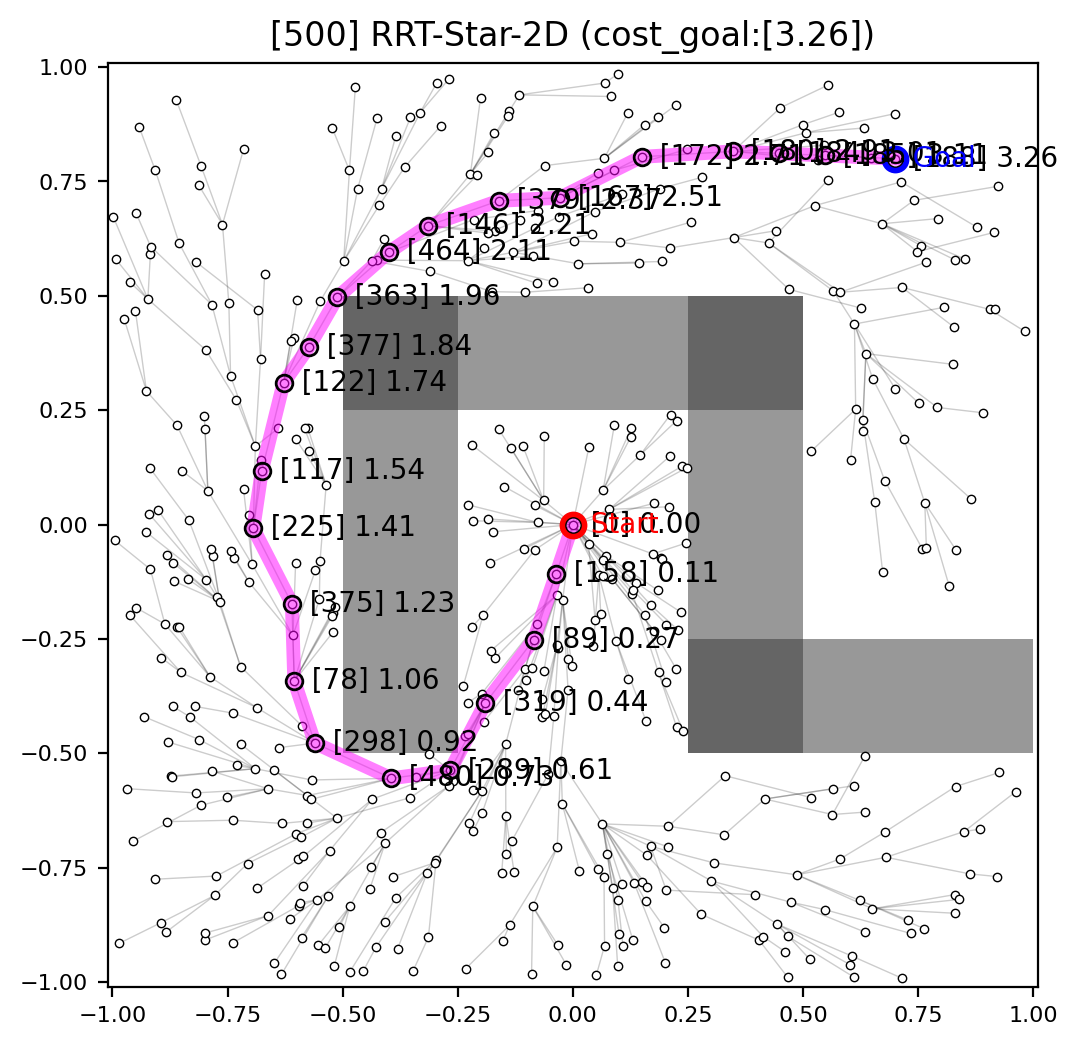

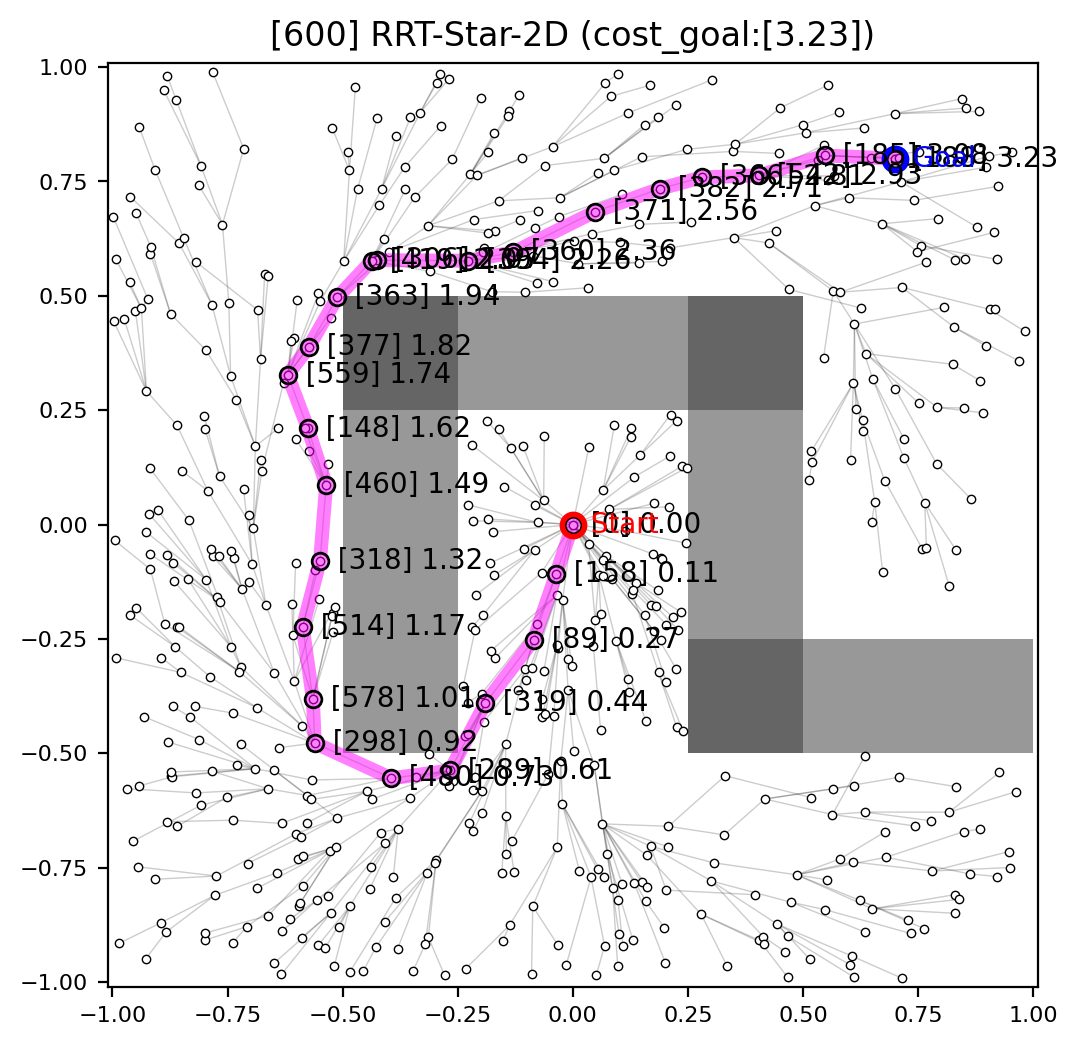

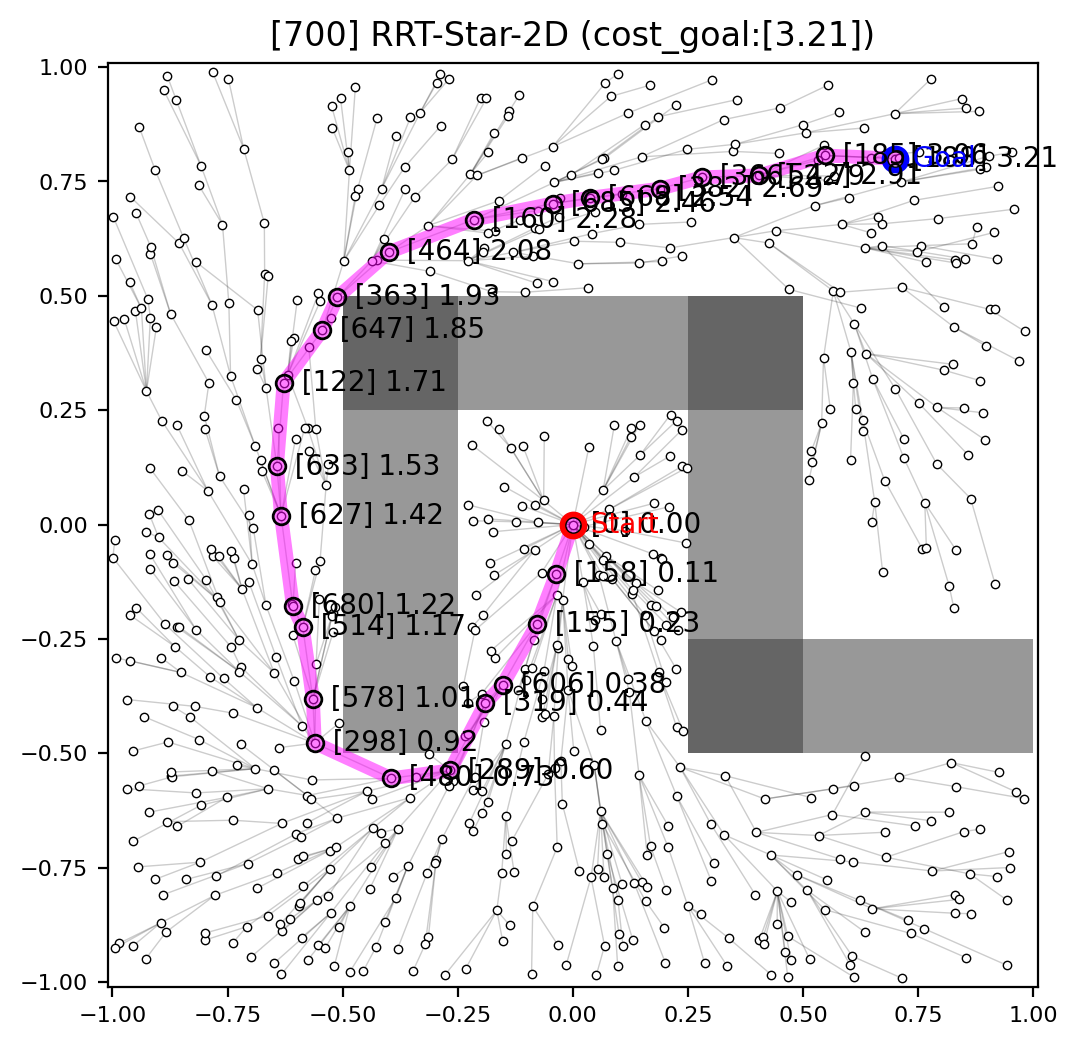

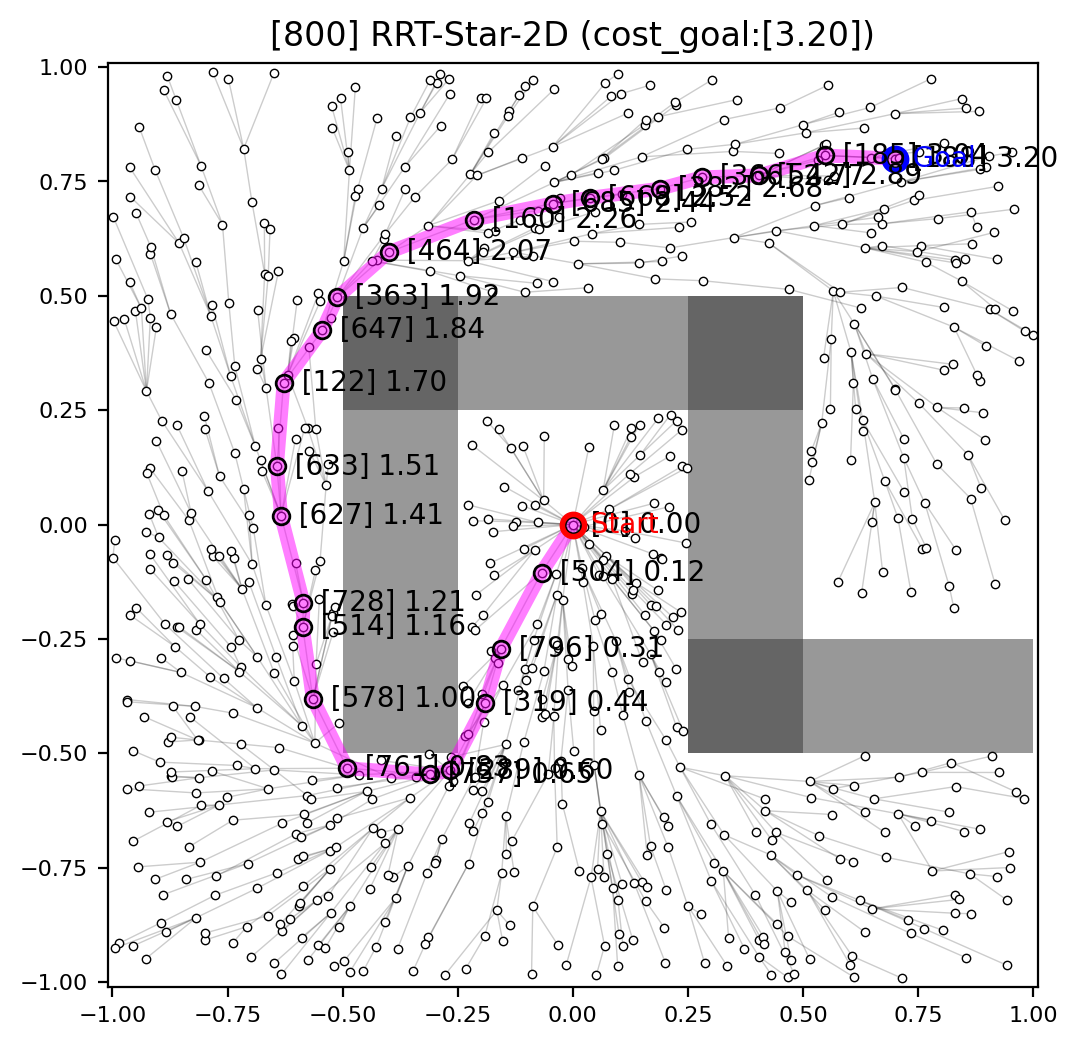

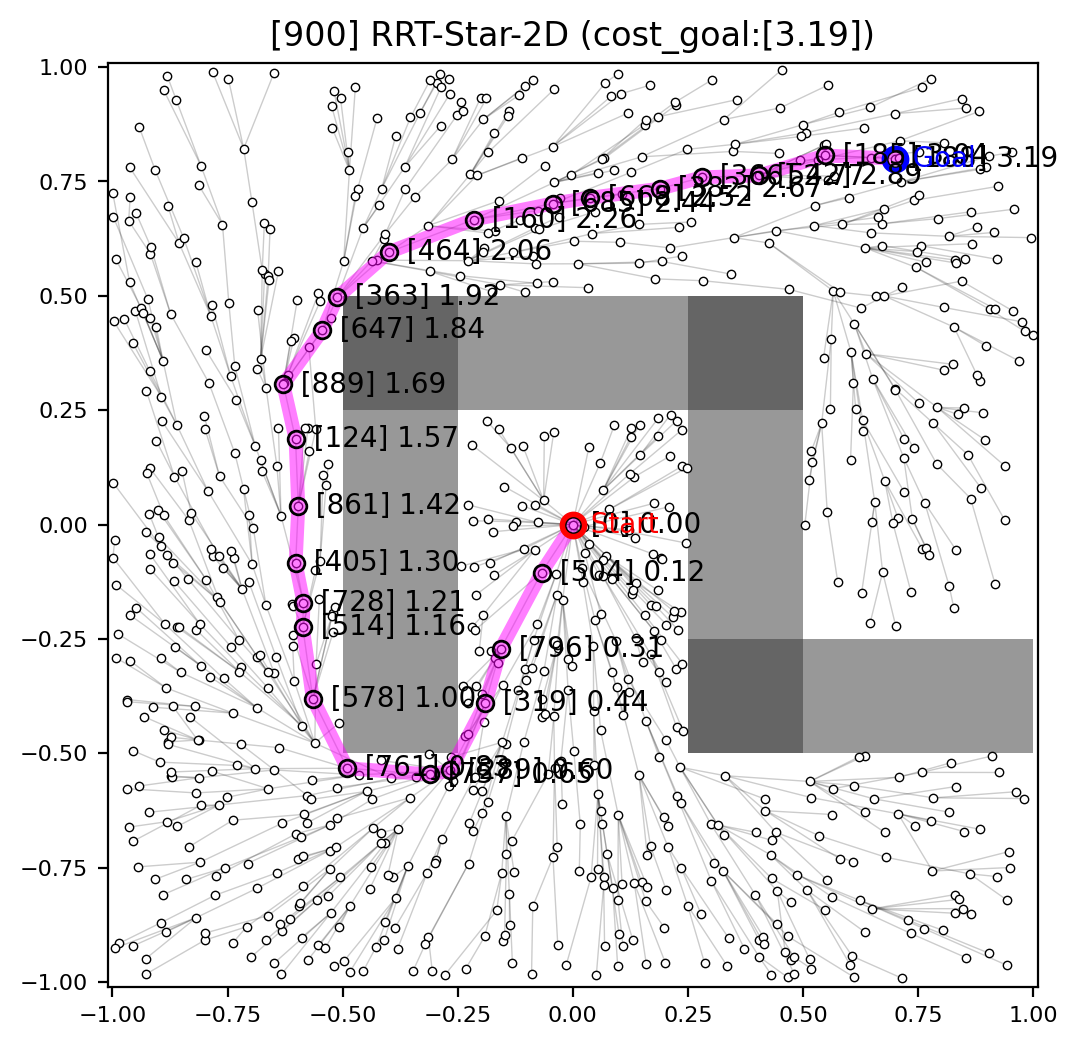

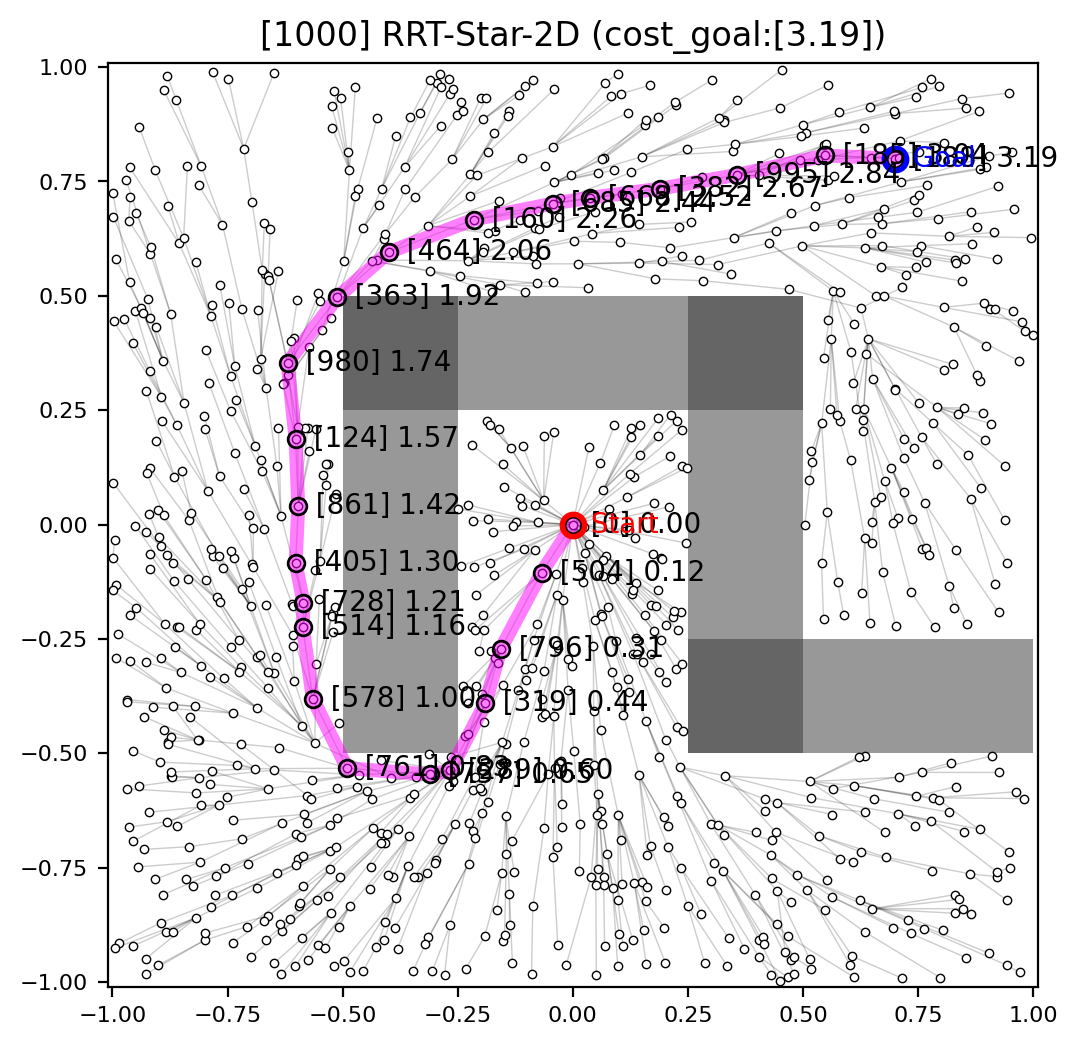

Done.


In [4]:
point_goal=np.array([0.7,0.8])
RRT.init_tree(point_root=np.zeros(RRT.dim),point_goal=point_goal)
n_node_max = 1000
TERMINATE_WHEN_GOAL_REACHED = False
loop_cnt = 0
while RRT.get_n_node() <= n_node_max:
    loop_cnt = loop_cnt + 1
    # Random sampling
    if np.random.rand() <= 0.1: # goal bias rate
        point_sample = RRT.point_goal
    else:
        point_sample = RRT.sample_point()
    if not is_point_feasible(point_sample,obs_list): continue
        
    # Get nearest node
    node_nearest = RRT.get_node_nearest(point_sample)
    point_nearest = RRT.get_node_point(node_nearest)
    
    # Steering towards 'point_sample'
    point_new,cost_new = RRT.steer(node_nearest,point_sample)
    if point_new is None: continue

    # Rewiring 
    if is_point_feasible(point_new,obs_list) \
        and is_point_to_point_connectable(point_nearest,point_new,obs_list):
        
        # Assign 'node_min' and initialize 'cost_min' with 'cost_new'
        node_min = node_nearest.copy()
        cost_min = cost_new
        
        # Select a set of nodes near 'point_new' => 'nodes_near'
        nodes_near = RRT.get_nodes_near(point_new)

        # For all 'node_near'
        for node_near in nodes_near:
            point_near,cost_near = RRT.get_node_point_and_cost(node_near)
            if is_point_to_point_connectable(point_near,point_new,obs_list):
                cost_prime = cost_near + RRT.get_dist(point_near,point_new)
                if cost_prime < cost_min:
                    cost_min = cost_near + RRT.get_dist(point_near,point_new)
                    node_min = node_near
                    
        # Add 'node_new' and connect it with 'node_min'
        node_new = RRT.add_node(point=point_new,cost=cost_min,node_parent=node_min)
        
        # New node information
        point_new,cost_new = RRT.get_node_point_and_cost(node_new)
        
        # Rewire
        for node_near in nodes_near:
            point_near,cost_near = RRT.get_node_point_and_cost(node_near)
            if ((cost_new+RRT.get_dist(point_near,point_new)) < cost_near) and \
                is_point_to_point_connectable(point_near,point_new,obs_list):
                RRT.replace_node_parent(node=node_near,node_parent_new=node_new)
                
    # Re-update cost of all nodes
    RRT.update_nodes_cost(VERBOSE=False)

    # Debug 
    if (RRT.get_n_node() % 100) == 0:
        node_goal = RRT.get_node_goal()
        if node_goal is not None: cost_goal = RRT.get_node_cost(node_goal)
        else: cost_goal = np.inf
        RRT.plot_tree_custom(
            figsize=(6,6),xlim=(-1.01,1.01),ylim=(-1.01,1.01),
            nodems=3,nodemec='k',nodemfc='w',nodemew=1/2,
            edgergba=[0,0,0,0.2],edgelw=1/2,
            obsrgba=[0.2,0.2,0.2,0.5],
            startrgb=[1,0,0],startms=8,startmew=2,startfs=10,
            goalrgb=[0,0,1],goalms=8,goalmew=2,goalfs=10,
            pathrgba=[1,0,1,0.5],pathlw=5,pathtextfs=10,
            obs_list=obs_list,
            textfs=8,titlestr='[%d] %s (cost_goal:[%.2f])'%(RRT.get_n_node(),RRT.name,cost_goal),titlefs=12,
            PLOT_FULL_TEXT=False)

    # Terminate condition
    dist_to_goal = RRT.get_dist_to_goal()
    if (dist_to_goal < 1e-6) and TERMINATE_WHEN_GOAL_REACHED:
        print ("Goad reached. n_node:[%d] dist_to_goal:[%.4f]"%
               (RRT.get_n_node(),dist_to_goal))
        break
print ("Done.")

### Get path to goal

In [5]:
path_to_goal,path_node_list = RRT.get_path_to_goal()
print ("path_to_goal: %s"%(path_to_goal.shape,))
print ("node_list: %s"%(path_node_list))

path_to_goal: (23, 2)
node_list: [0, 504, 796, 319, 289, 757, 761, 578, 514, 728, 405, 861, 124, 980, 363, 464, 160, 685, 668, 382, 995, 185, 188]


### Plot

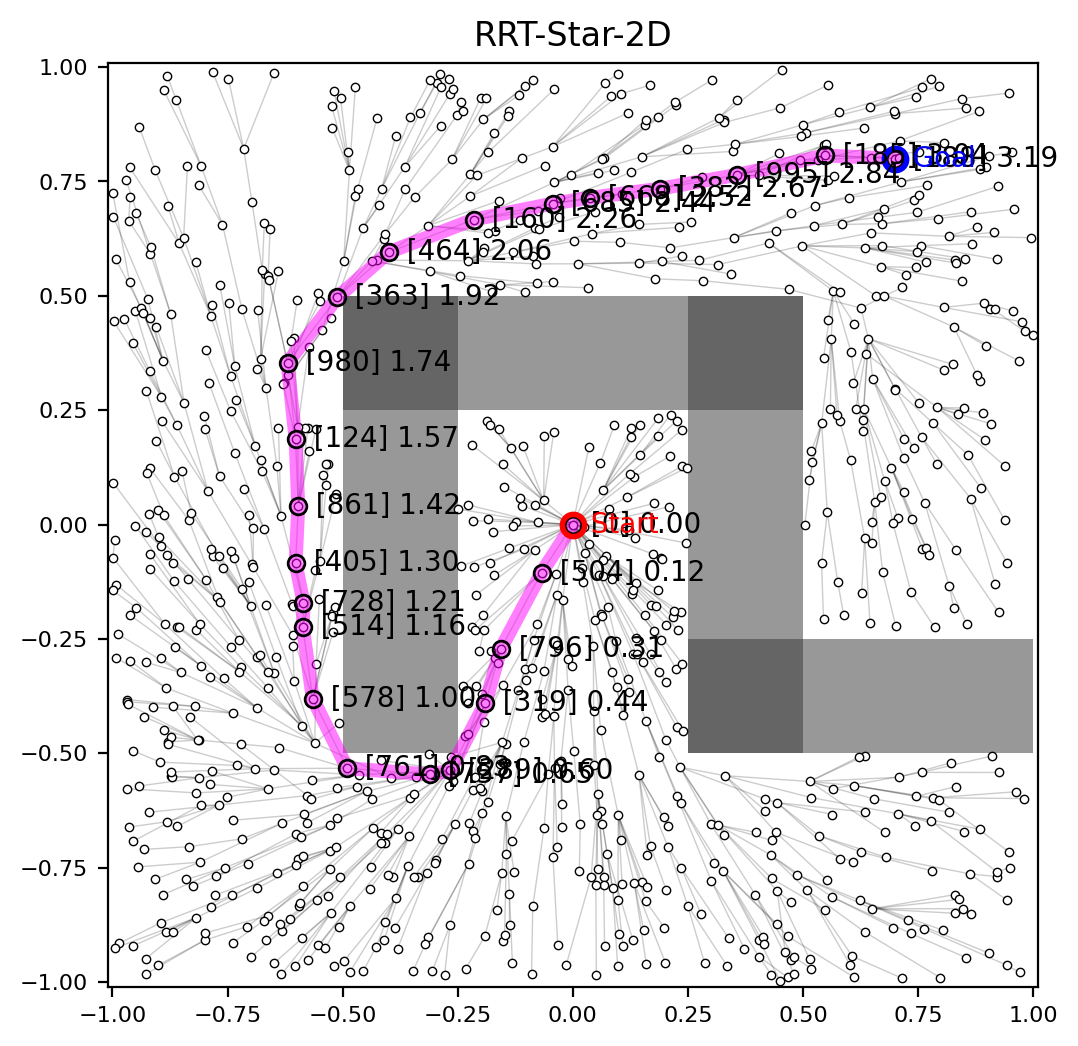

In [6]:
RRT.plot_tree_custom(
    figsize=(6,6),xlim=(-1.01,1.01),ylim=(-1.01,1.01),
    nodems=3,nodemec='k',nodemfc='w',nodemew=1/2,
    edgergba=[0,0,0,0.2],edgelw=1/2,
    obsrgba=[0.2,0.2,0.2,0.5],
    startrgb=[1,0,0],startms=8,startmew=2,startfs=10,
    goalrgb=[0,0,1],goalms=8,goalmew=2,goalfs=10,
    pathrgba=[1,0,1,0.5],pathlw=5,pathtextfs=10,
    obs_list=obs_list,
    textfs=8,titlestr='%s'%(RRT.name),titlefs=12,
    PLOT_FULL_TEXT=False)